# SHAP Explainability Analysis (C1: CatBoost)

This notebook applies SHAP-based explainability techniques to the final CatBoost model.

**Purpose:**  
To provide global and local explanations of model predictions and support transparent interpretation of screening outcomes.

In [1]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap
from catboost import CatBoostClassifier

In [24]:
# PATHS
NOTEBOOK_DIR = Path.cwd()                
PROJECT_ROOT = NOTEBOOK_DIR.parent        

DATA_DIR = PROJECT_ROOT / "data"
SRC_DIR = PROJECT_ROOT / "src"
OUT_DIR = PROJECT_ROOT / "results" / "SHAP"
OUT_DIR.mkdir(parents=True, exist_ok=True)

sys.path.insert(0, str(SRC_DIR))

from common_setup import load_arff, prepare_df_AQ_DEMO

ADULT_ARFF_PATH = DATA_DIR / "Autism-Adult-Data.arff"
CHILD_ARFF_PATH = DATA_DIR / "Autism-Child-Data.arff"

In [3]:
# LOAD + PREP 

adult_raw = load_arff(ADULT_ARFF_PATH)
child_raw = load_arff(CHILD_ARFF_PATH)

Xa, ya, num_adult, cat_adult, feat_adult = prepare_df_AQ_DEMO(adult_raw, "Adult")
Xc, yc, num_child, cat_child, feat_child = prepare_df_AQ_DEMO(child_raw, "Child")

# cat feature indices for CatBoost
cat_idx_adult = [Xa.columns.get_loc(c) for c in cat_adult]
cat_idx_child = [Xc.columns.get_loc(c) for c in cat_child]

print("Adult cat idx:", cat_idx_adult)
print("Child cat idx:", cat_idx_child)


[Adult] AQ columns: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
[Adult] Dropping leaky column 'result'
[Adult] Using label column: 'Class/ASD'
[Adult] X shape: (704, 19)
[Adult] y counts: [515 189]

[Child] AQ columns: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
[Child] Dropping leaky column 'result'
[Child] Using label column: 'Class/ASD'
[Child] X shape: (292, 19)
[Child] y counts: [151 141]
Adult cat idx: [13, 14, 15, 16, 17, 18]
Child cat idx: [13, 14, 15, 16, 17, 18]


In [4]:
# TRAIN FINAL C1 MODELS
# Use exactly the same hyperparams as C1 notebook

C1_PARAMS = dict(
    loss_function="Logloss",
    depth=5,
    learning_rate=0.1,
    iterations=400,
    random_seed=42,
    verbose=False
)

cb_adult = CatBoostClassifier(**C1_PARAMS)
cb_child = CatBoostClassifier(**C1_PARAMS)

cb_adult.fit(Xa, ya, cat_features=cat_idx_adult)
cb_child.fit(Xc, yc, cat_features=cat_idx_child)

print("Trained final C1 models on full Adult + Child datasets.")

Trained final C1 models on full Adult + Child datasets.


In [5]:
# SHAP EXPLAINERS (TreeExplainer)

expl_adult = shap.TreeExplainer(cb_adult)
expl_child = shap.TreeExplainer(cb_child)

# Small background sample for speed + stable plots
bg_adult = Xa.sample(n=min(200, len(Xa)), random_state=42)
bg_child = Xc.sample(n=min(200, len(Xc)), random_state=42)

# Compute SHAP values
sv_adult = expl_adult.shap_values(bg_adult)
sv_child = expl_child.shap_values(bg_child)

# CatBoost + SHAP sometimes returns list for binary. Make it robust:
def unwrap_binary_shap(shap_vals):
    # If list-like with 2 classes, take class 1 (ASD-positive)
    if isinstance(shap_vals, list) and len(shap_vals) == 2:
        return shap_vals[1]
    return shap_vals

sv_adult = unwrap_binary_shap(sv_adult)
sv_child = unwrap_binary_shap(sv_child)

print("SHAP computed:")
print("Adult shap shape:", np.array(sv_adult).shape)
print("Child shap shape:", np.array(sv_child).shape)

SHAP computed:
Adult shap shape: (200, 19)
Child shap shape: (200, 19)


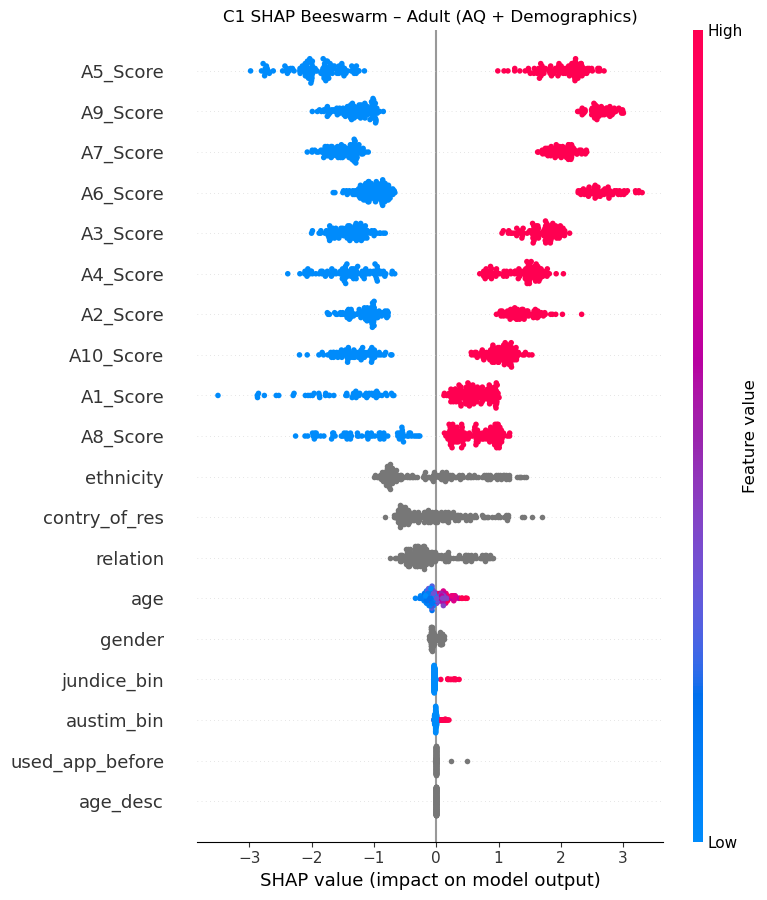

In [6]:
# Adult summary (beeswarm) 
plt.figure()
shap.summary_plot(sv_adult, bg_adult, show=False)
plt.title("C1 SHAP Beeswarm – Adult (AQ + Demographics)")
plt.tight_layout()
plt.savefig(OUT_DIR / "C1_adult_SHAP_summary_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

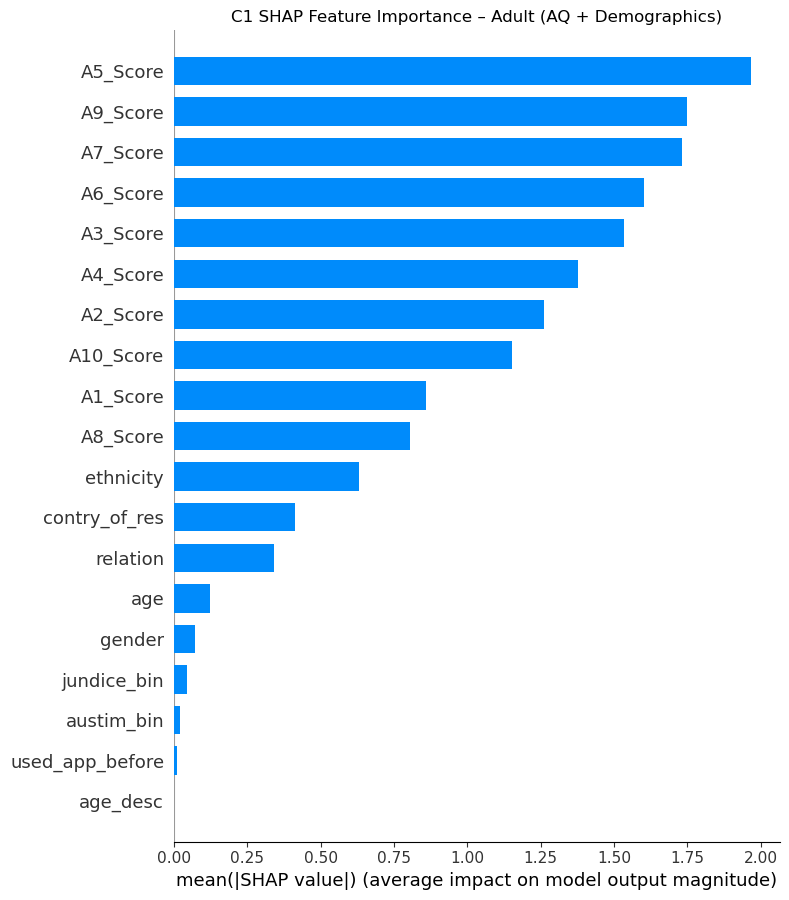

In [7]:
# Adult summary (bar) 
plt.figure()
shap.summary_plot(sv_adult, bg_adult, plot_type="bar", show=False)
plt.title("C1 SHAP Feature Importance – Adult (AQ + Demographics)")
plt.tight_layout()
plt.savefig(OUT_DIR / "C1_adult_SHAP_summary_bar.png", dpi=300, bbox_inches="tight")
plt.show()

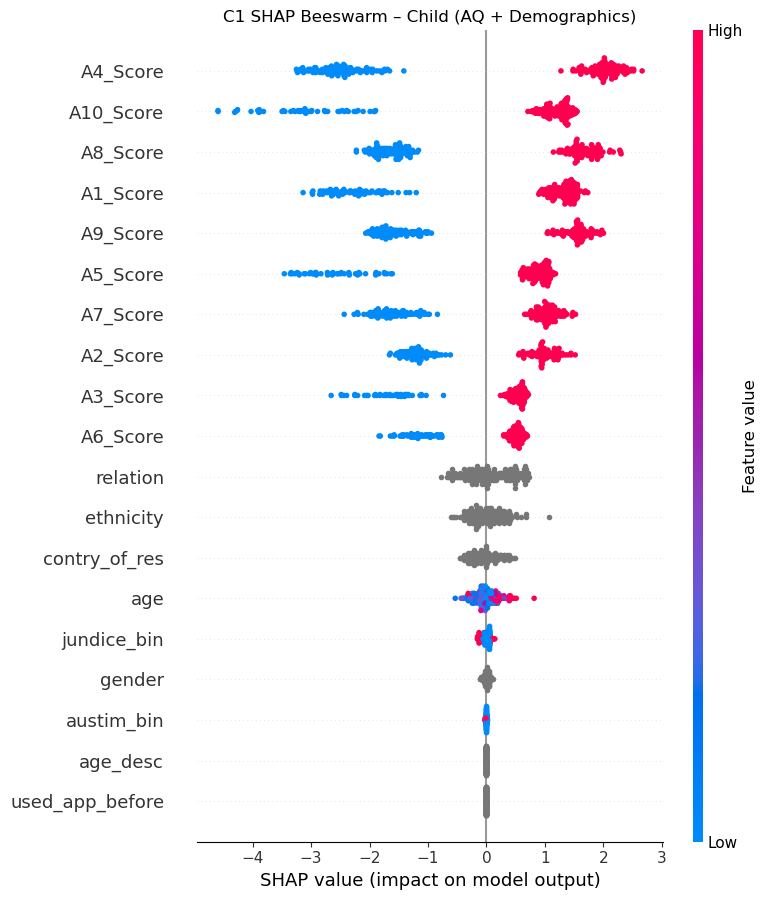

In [8]:
# Child summary (beeswarm)
plt.figure()
shap.summary_plot(sv_child, bg_child, show=False)
plt.title("C1 SHAP Beeswarm – Child (AQ + Demographics)")
plt.tight_layout()
plt.savefig(OUT_DIR / "C1_child_SHAP_summary_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()


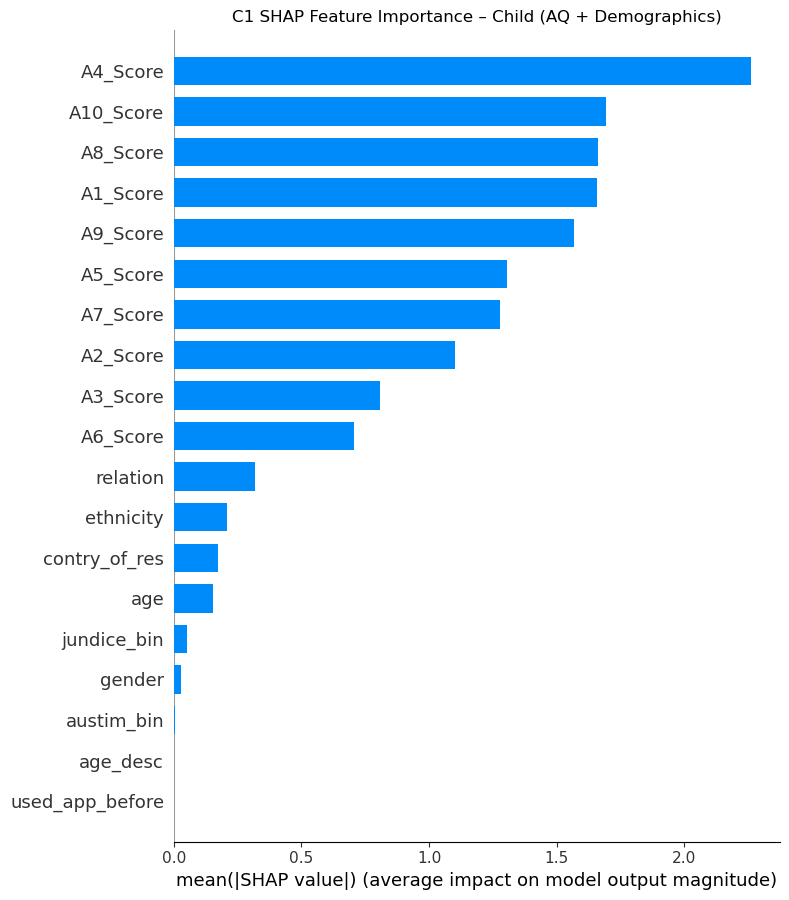

In [9]:
# Child summary (bar) 
plt.figure()
shap.summary_plot(sv_child, bg_child, plot_type="bar", show=False)
plt.title("C1 SHAP Feature Importance – Child (AQ + Demographics)")
plt.tight_layout()
plt.savefig(OUT_DIR / "C1_child_SHAP_summary_bar.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
#LOCAL EXPLANATIONS (waterfall)

def pick_case_indices(X, y, model):
    # choose a confident positive and confident negative based on predicted proba
    proba = model.predict_proba(X)[:, 1]
    idx_pos = int(np.argmax(proba))
    idx_neg = int(np.argmin(proba))
    return idx_pos, idx_neg, proba[idx_pos], proba[idx_neg]

adult_pos_i, adult_neg_i, adult_pos_p, adult_neg_p = pick_case_indices(Xa, ya, cb_adult)
child_pos_i, child_neg_i, child_pos_p, child_neg_p = pick_case_indices(Xc, yc, cb_child)

print("Adult: pos idx", adult_pos_i, "p", adult_pos_p, "| neg idx", adult_neg_i, "p", adult_neg_p)
print("Child: pos idx", child_pos_i, "p", child_pos_p, "| neg idx", child_neg_i, "p", child_neg_p)

Adult: pos idx 653 p 0.9999997830328922 | neg idx 376 p 1.3954081662369374e-07
Child: pos idx 38 p 0.9999988045312683 | neg idx 55 p 1.2811243514293983e-06


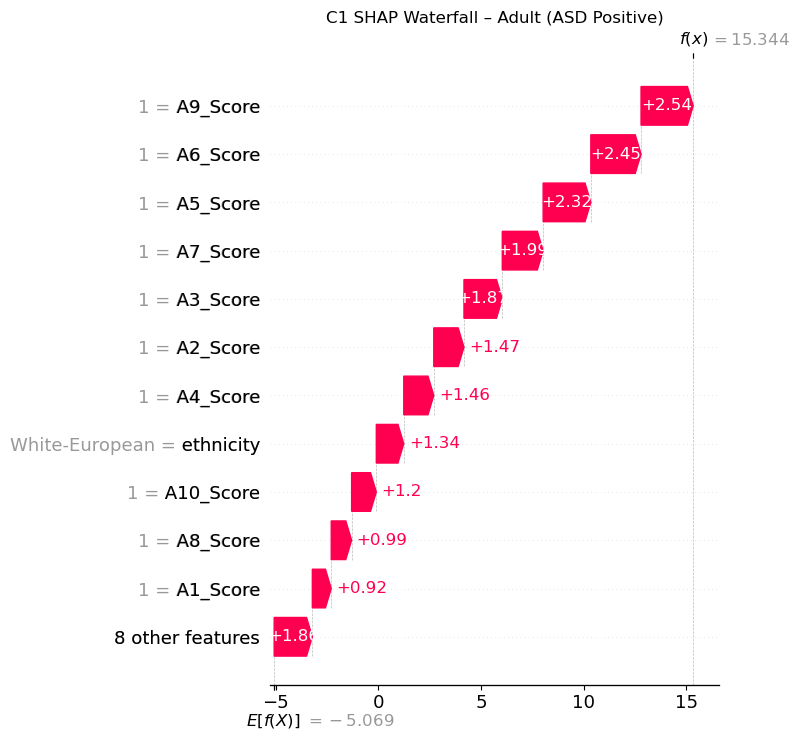

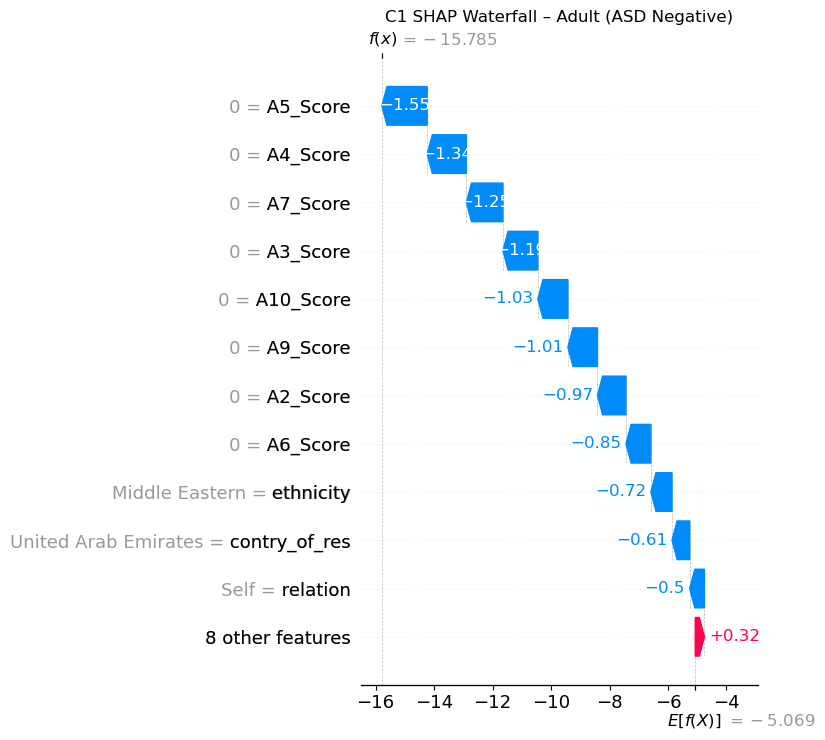

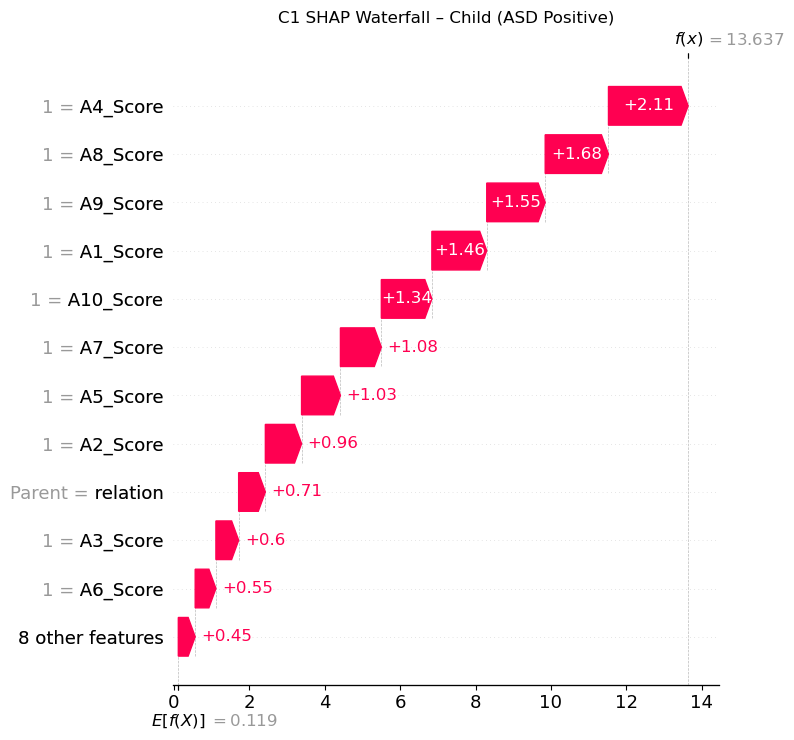

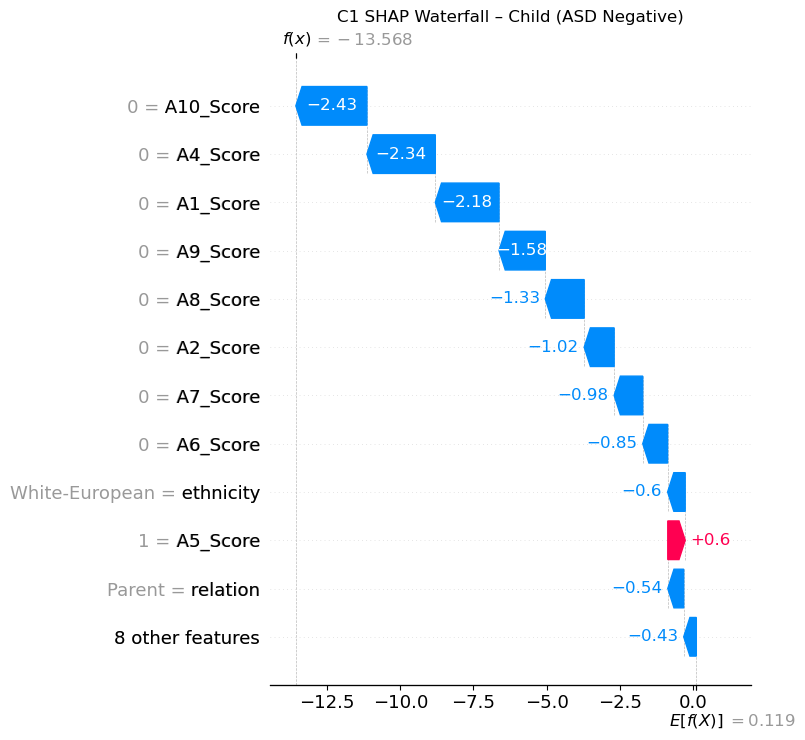

In [11]:
# single-case SHAP values + waterfall
def save_waterfall(explainer, X_full, case_idx, fname, title):
    x_row = X_full.iloc[[case_idx]]
    sv = explainer.shap_values(x_row)
    sv = unwrap_binary_shap(sv)

    exp = shap.Explanation(
        values=sv[0],
        base_values=np.array(explainer.expected_value).reshape(-1)[0],
        data=x_row.iloc[0].values,
        feature_names=X_full.columns
    )

    plt.figure()
    shap.plots.waterfall(exp, show=False, max_display=12)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(OUT_DIR / fname, dpi=300, bbox_inches="tight")
    plt.show()

save_waterfall(
    expl_adult, Xa, adult_pos_i,
    "C1_adult_SHAP_waterfall_ASD_positive.png",
    "C1 SHAP Waterfall – Adult (ASD Positive)"
)

save_waterfall(
    expl_adult, Xa, adult_neg_i,
    "C1_adult_SHAP_waterfall_ASD_negative.png",
    "C1 SHAP Waterfall – Adult (ASD Negative)"
)

save_waterfall(
    expl_child, Xc, child_pos_i,
    "C1_child_SHAP_waterfall_ASD_positive.png",
    "C1 SHAP Waterfall – Child (ASD Positive)"
)

save_waterfall(
    expl_child, Xc, child_neg_i,
    "C1_child_SHAP_waterfall_ASD_negative.png",
    "C1 SHAP Waterfall – Child (ASD Negative)"
)
